# Let's try an embedding

General idea:

* 3 channel image of n x n
* Channel 1: 
  * Each category gets n_cat / n_rows
  * Category get's heatmap with relational embedding (where it falls on the table)
* Channel 2:
  * Numerical values
  * Heatmap based on how far away it is from the mean (light up it to mean on a gradient)
  * Numericals get n_cont / n_rows
* Channel 3:
  * We assume a relationship between channel 1 (our cats) and channel 2 (our conts)
  * Channel 3 = Channel 1 * Channel 2

In [0]:
import os
!pip install -q torch torchvision feather-format kornia pyarrow Pillow wandb nbdev fastprogress --upgrade 
!pip install -q git+https://github.com/fastai/fastcore  --upgrade
!pip install -q git+https://github.com/fastai/fastai2 --upgrade
os._exit(00)

In [0]:
from fastai2.basics import *
from fastai2.tabular.all import *
from fastai2.callback.all import *

In [0]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

We'll need to pre-process our data

In [0]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]

In [0]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names='salary')

Now that we have this, we can grab a processed `DataFrame` with `to.items`

In [0]:
proc_df = to.items

In [7]:
proc_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,age_na,fnlwgt_na,education-num_na
0,0.763796,5,-0.838084,8,0.752401,3,0,6,5,Female,0,1902,40,United-States,1,1,1,1
1,0.397233,5,0.444987,13,1.535589,1,5,2,5,Male,10520,0,45,United-States,1,1,1,1
2,-0.042642,5,-0.886734,12,-0.030788,1,0,5,3,Female,0,0,32,United-States,0,1,1,2
3,-0.042642,6,-0.728873,15,1.927183,3,11,1,2,Male,0,0,40,United-States,1,1,1,1
4,0.250608,7,-1.018314,6,-0.030788,3,9,6,3,Female,0,0,50,United-States,0,1,1,2


# Channel 1

To reiterate:

* Each category gets n_cat / n_rows
* Category get's heatmap with relational embedding (where it falls on the table)

In [8]:
len(cat_names), cat_names

(9,
 ['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'age_na',
  'fnlwgt_na',
  'education-num_na'])

We can extract just the categories

In [9]:
cats = to.cats; cats.head()

,workclass,education,marital-status,occupation,relationship,race,age_na,fnlwgt_na,education-num_na
0,5,8,3,0,6,5,1,1,1
1,5,13,1,5,2,5,1,1,1
2,5,12,1,0,5,3,1,1,2
3,6,15,3,11,1,2,1,1,1
4,7,6,3,9,6,3,1,1,2


For experimentation's simplicity, we will use 224x224 as our image size. Let's start with `workclass`

In [10]:
cats['workclass'].nunique()

9

In [11]:
224/9

24.88888888888889

Each value will get 24 pixels with the last getting 25

In [0]:
arr = np.zeros((224, 25))

In [13]:
arr.shape

(224, 25)

1. Glance at what the actual value is
2. Glance at how many values per spot we get
3. If not the maximum value, fill with x spots
4. If is, fill the very end x spots + 1

In [0]:
img_len = 100
val = 5
n = 9

In [15]:
row_sz = int(img_len/n); row_sz

11

In [16]:
start = row_sz * val; start

55

In [17]:
end = start + row_sz; end

66

In [18]:
arr = np.zeros((row_sz, img_len)); arr.shape

(11, 100)

In [0]:
arr[:, start:end] = val

In [20]:
arr.shape

(11, 100)

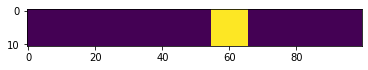

In [21]:
plt.imshow(arr)

In [0]:
def get_arr(val, n, row_height, img_len): 
  # Take care of if last row is partial
  row_pos = int(img_len/n)
  if n == val:
    start = img_len - row_pos
    end = img_len
  start = row_pos * val
  end = start + row_pos
  arr = np.zeros((row_height, img_len))
  arr[:, start:end] = val
  return arr

In [0]:
def get_cat_row(row, dic, img_len):
  row_height = int(img_len/len(row))
  for i, val in enumerate(row):
    if i > 0:
      temp = arr
    arr = get_arr(val, dic[i], row_height, img_len)
    if i > 0:
      arr = np.append(arr, temp, axis = 0)
  if arr.shape != (img_len, img_len):
    diff = img_len - arr.shape[1]
    np.pad(arr, [(0,diff), (0,0)],mode='constant')
  return arr

In [0]:
vals = cats.nunique()

In [0]:
# if any are boolean, make it two
for i, val in enumerate(vals):
  if val == 1:
    vals[i] = 2

Let's try it out

In [0]:
i = get_cat_row(cats.iloc[0], vals, 100)

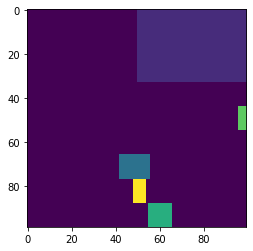

In [28]:
plt.imshow(i)

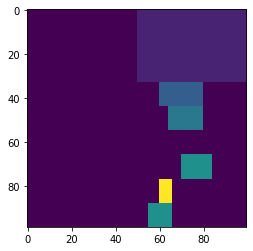

In [29]:
j = get_cat_row(cats.iloc[10], vals, 100); plt.imshow(j)

Categoricals are done!

# Channel 2:
* Numerical
* Heatmap based on how far away it is from the mean (light up it to mean on a gradient)
* Numericals get n_cont / n_rows

In [0]:
def to_gaussian(x:int, sig:int, height:int, width:int):
  # Make a gaussian for a point and its standard deviation
  y = height//2
  x1 = np.arange(-1, width-1, 1, float)
  y1 = np.array([0]*height)[:, np.newaxis]
  return np.exp(-((x1-x)**2 + (y1-y)**2)/(2*sig**2))

In [0]:
heatmap = to_gaussian(20, 5, 10, 100)

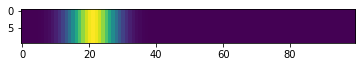

In [32]:
plt.imshow(heatmap)

In [0]:
conts = df[cont_names]

For this we will use the raw values. We'll go backwards and forwards by .5 standard deviations

In [34]:
conts.head()

,age,fnlwgt,education-num
0,49,101320,12.0
1,44,236746,14.0
2,38,96185,NaN
3,38,112847,15.0
4,42,82297,NaN


In [0]:
heatmap = to_gaussian(49, conts['age'].std()/2, 10, 100)

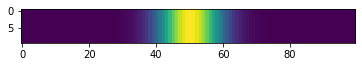

In [36]:
plt.imshow(heatmap)

In [37]:
conts.std()

age                  13.640433
fnlwgt           105549.977697
education-num         2.572999
dtype: float64

In [0]:
arr = np.array([[0,0,1],
                [0,1,0],
                [1,0,0]])

In [90]:
np.pad(arr, [(0,5), (0,0)],mode='constant')

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [0]:
def get_num_row(row, dic, img_len):
  row_height = int(img_len/len(row))
  for i, val in enumerate(row):
    if i > 0:
      temp = arr
    arr = to_gaussian(val, dic[i], row_height, img_len)
    if i > 0:
      arr = np.append(arr, temp, axis = 0)
  return arr

In [0]:
heatmaps = get_num_row(conts.iloc[6], conts.std(), 100)

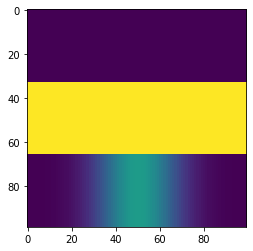

In [93]:
plt.imshow(heatmaps)

Now we have the second channel!

# Channel 3
* Multiplication of the first two 

In [0]:
cat_row = cats.iloc[0]
cont_row = conts.iloc[0]

In [0]:
cont_hmp = get_num_row(cont_row, conts.std(), 224)
cat_hmp = get_cat_row(cat_row, cats.nunique(), 224)

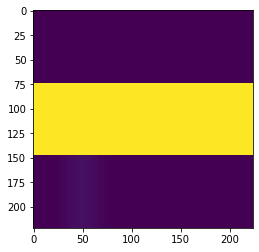

In [75]:
plt.imshow(cont_hmp)

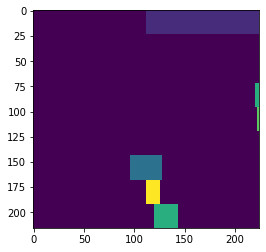

In [76]:
plt.imshow(cat_hmp)

In [77]:
cat_hmp.shape == cont_hmp.shape

False

In [0]:
new = cont_hmp * cat_hmp

In [47]:
new.shape

(99, 100)

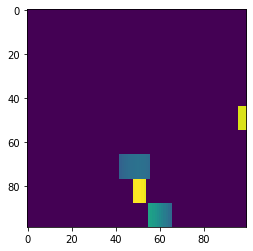

In [48]:
plt.imshow(new)

In [0]:
mask = np.array([cat_hmp, cont_hmp, new])

In [0]:
from fastai2.vision.all import *

In [0]:
im = Image.fromarray(mask.transpose(1,2,0), 'RGB')

In [53]:
mask.shape

(3, 99, 100)

In [0]:
get_num_row??

In [0]:
def make_im(row, proc_row, conts, cats, cat_uniq, cont_std, im_size):
  cont_hmp = get_num_row(row[conts], cont_std, im_size)
  cat_hmp = get_cat_row(proc_row[cats], cat_uniq, im_size)
  hybrid = cont_hmp * cat_hmp
  return np.array([cont_hmp, cat_hmp, hybrid]).transpose(1,2,0)

In [0]:
im = make_im(df.iloc[0], proc_df.iloc[0], cont_names, cat_names, 
             proc_df[cat_names].nunique(), df[cont_names].std(), 100)

In [0]:
im = Image.fromarray(im.transpose(1,2,0), 'RGB')

In [57]:
df['salary'].unique()

array(['>=50k', '<50k'], dtype=object)

In [58]:
proc_df['salary'].unique()

array([1, 0])

In [60]:
df['salary'].iloc[0], proc_df['salary'].iloc[0]

('>=50k', 1)

In [0]:
above = df[df['salary'] == '>=50k']
above_proc = proc_df[proc_df['salary'] == 1]

In [62]:
len(above) == len(above_proc)

True

In [0]:
!rm -r 'above'
!rm -r 'below'

In [0]:
!mkdir above
!mkdir below

In [0]:
def get_cat_row(row, dic, img_len):
  row_height = int(img_len/len(row))
  for i, val in enumerate(row):
    if i > 0:
      temp = arr
    arr = get_arr(val, dic[i], row_height, img_len)
    if i > 0:
      arr = np.append(arr, temp, axis = 0)
  if arr.shape != (img_len, img_len):
    diff = img_len - arr.shape[0]
    arr = np.pad(arr, [(0,diff), (0,0)])
  return arr

In [0]:
def get_num_row(row, dic, img_len):
  row_height = int(img_len/len(row))
  for i, val in enumerate(row):
    if i > 0:
      temp = arr
    arr = to_gaussian(val, dic[i], row_height, img_len)
    if i > 0:
      arr = np.append(arr, temp, axis = 0)
  if arr.shape != (img_len, img_len):
    diff = img_len - arr.shape[0]
    arr = np.pad(arr, [(0,diff), (0,0)])
  return arr

In [0]:
vals = above_proc[cat_names].nunique()
for i, val in enumerate(vals):
  if val == 1:
    vals[i] = 2

In [0]:
cat_row = get_cat_row(cats.iloc[0], vals, 224)

In [0]:
!rm -r above
!mkdir above

In [0]:
!rm -r below
!mkdir below

In [154]:
for i in progress_bar(range(len(above))):
  cats = above_proc[cat_names]
  conts = above[cont_names]
  cat_row = get_cat_row(cats.iloc[i], vals, 224)
  cont_row = get_num_row(conts.iloc[i], conts.std(), 224)
  hybrid = cat_row * cont_row
  im = np.array([cont_row, cat_row, hybrid]).transpose(1,2,0)
  im = Image.fromarray(im, 'RGB')
  im.save(f'above/image_{i}.jpg')

In [155]:
below = df[df['salary'] == '<50k']
below_proc = proc_df[proc_df['salary'] == 0]
len(below) == len(below_proc)

True

In [156]:
for i in progress_bar(range(len(below))):
  cats = below_proc[cat_names]
  conts = below[cont_names]
  cat_row = get_cat_row(cats.iloc[i], vals, 224)
  cont_row = get_num_row(conts.iloc[i], conts.std(), 224)
  hybrid = cat_row * cont_row
  im = np.array([cont_row, cat_row, hybrid]).transpose(1,2,0)
  im = Image.fromarray(im, 'RGB')
  im.save(f'below/image_{i}.jpg')

Now let's try making our databunch!

In [0]:
adults = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(0.2),
                  get_y=parent_label)

In [0]:
path = Path('.')

In [0]:
dbunch = adults.databunch(path, item_tfms=RandomResizedCrop(460), bs=32,
                batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

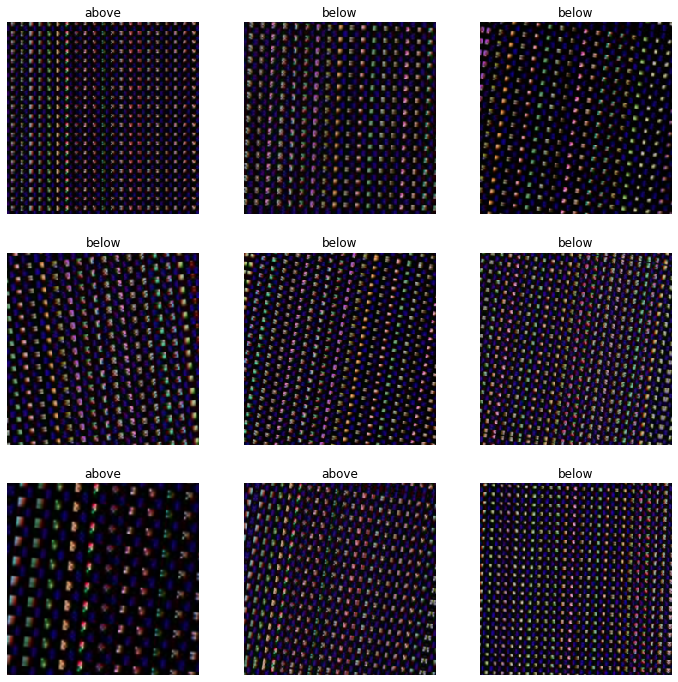

In [6]:
dbunch.show_batch(figsize=(12,12))

In [0]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=accuracy)

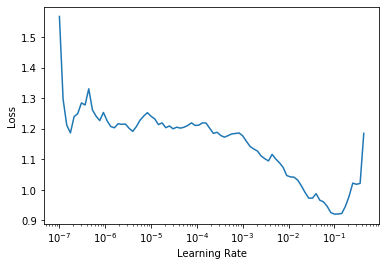

In [167]:
learn.lr_find()

In [170]:
learn.fit_one_cycle(10, slice(1e-3))

KeyboardInterrupt: ignored

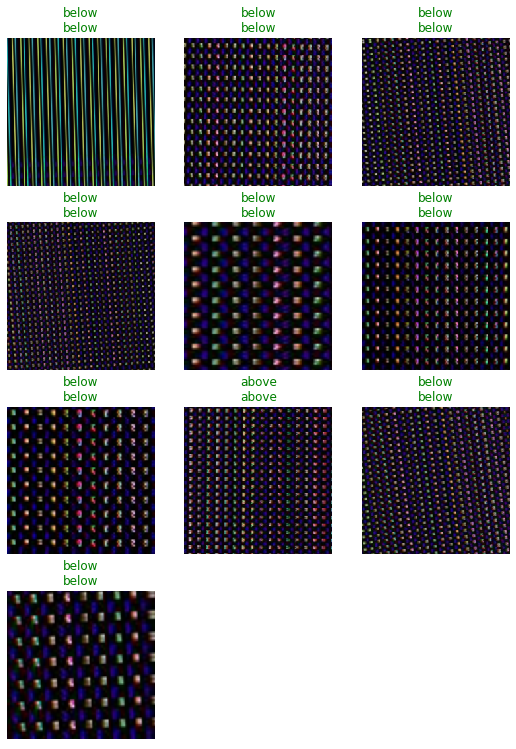

In [171]:
learn.show_results()

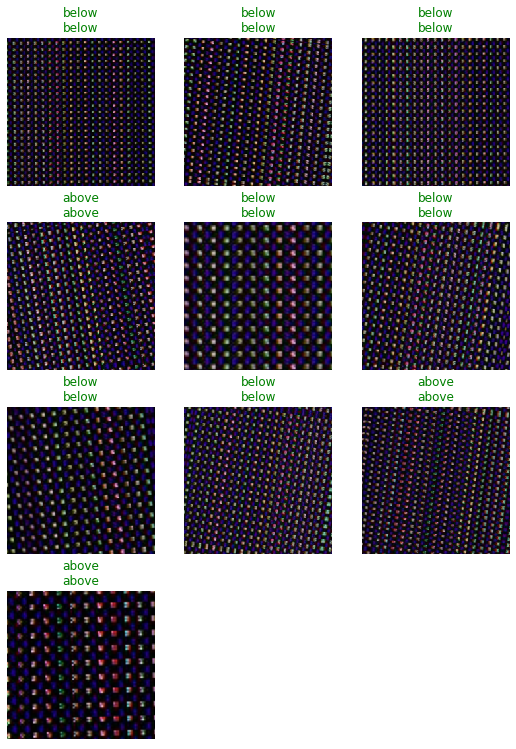

In [172]:
learn.show_results()

In [173]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [174]:
interp.most_confused()

[('above', 'below', 9)]

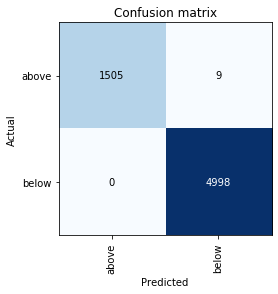

In [175]:
interp.plot_confusion_matrix()

In [7]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=accuracy)
learn.fit_one_cycle(2, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.145716,0.023930,0.996315,04:58
1,0.076102,0.013420,0.997082,04:53


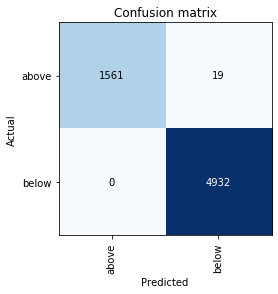

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [9]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=accuracy)
learn.fit_one_cycle(2, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.128969,0.023523,0.996315,04:54
1,0.084001,0.013501,0.997082,04:53


In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=accuracy)
learn.fit_one_cycle(2, slice(1e-3))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=accuracy)
learn.fit_one_cycle(2, slice(1e-3))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=accuracy)
learn.fit_one_cycle(2, slice(1e-3))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=accuracy)
learn.fit_one_cycle(2, slice(1e-3))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=accuracy)
learn.fit_one_cycle(2, slice(1e-3))

In [1]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

NameError: ignored

In [0]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=accuracy)
learn.fit_one_cycle(2, slice(1e-3))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=accuracy)
learn.fit_one_cycle(2, slice(1e-3))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=accuracy)
learn.fit_one_cycle(2, slice(1e-3))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()